In [2]:
!pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.9 MB/s eta 0:00:00


In [3]:
!pip install sparqlwrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# First let's setup the endpoint
from SPARQLWrapper import SPARQLWrapper, JSON

# if the SPARQL endpoint is down, you still have all the sources in our GitHub repository:
# https://github.com/TEC-Toolkit/cfkg
sparql = SPARQLWrapper(
    "https://sparql.cf.linkeddata.es/cf"
)
sparql.setReturnFormat(JSON)

In [9]:
# Now we need to choose the conversion factor.
# This can be through a URI, or by determining emission source and emission target
# For example a CF that involves Butane and transforms to CO2e
# We also have to determine the Scope of the emission (e.g., scope 1)
# Since there are too many, we add a restriction for the scope and so that the
# entity produced is measured in kgs
sparql.setQuery("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX ecfo: <https://w3id.org/ecfo#>
    prefix qudt: <http://qudt.org/schema/qudt/>
select ?context ?cf ?s ?t where{
    ?cf ecfo:hasTag ?tag;
        ecfo:hasEmissionSource ?s;
        ecfo:hasEmissionTarget ?t;
        ecfo:hasTargetUnit ?tu;
        ecfo:hasScope <https://w3id.org/ecfo#Scope1>.
    ?tag rdfs:label "CNG"@en.
    ?t rdfs:label "carbon dioxide equivalent"@en .
    ?tu qudt:abbreviation "kg"@en.
   optional {
     ?cf <https://w3id.org/ecfo#hasAdditionalContext> ?context
   }
}
    """
)
#filter(regex(?context,"Net cv","i"))

ret = sparql.queryAndConvert()
for r in ret["results"]["bindings"]:
    print(r)


{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_17'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_21'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'context': {'type': 'literal', 'xml:lang': 'en', 'value': 'Net CV'}, 'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_25'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1933140'}}
{'context': {'type': 'literal', 'xml:lang': 'en', 'value': 'Gross CV'}, 'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_29'}, 's': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/Gaseous_fuels_CNG'}, 't': {'typ

In [19]:
# We see that we get elements within two contexts: Gross calorific value and net calorific value
# We are interested in the gross one, so we add a filter to our query

from datetime import datetime
sparql.setQuery("""
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX ecfo: <https://w3id.org/ecfo#>
    prefix qudt: <http://qudt.org/schema/qudt/>
select ?cf ?value ?start ?end ?context where{
    ?cf ecfo:hasTag ?tag;
        ecfo:hasEmissionSource ?s;
        ecfo:hasEmissionTarget ?t;
        ecfo:hasTargetUnit ?tu;
        ecfo:hasAdditionalContext ?context;
        rdf:value ?value;
        ecfo:hasScope ecfo:Scope1;
        ecfo:hasApplicablePeriod ?period.
    filter(regex(?context,"Gross cv","i")) .
    ?tag rdfs:label "CNG"@en.
    ?t rdfs:label "carbon dioxide equivalent"@en .
    ?tu qudt:abbreviation "kg"@en.
    ?period <http://www.w3.org/2006/time#hasBeginning>/<http://www.w3.org/2006/time#inXSDDate> ?start;
         <http://www.w3.org/2006/time#hasEnd>/<http://www.w3.org/2006/time#inXSDDate> ?end
}
    """
)
## we force the context in this case

values =[]
years =[]
ret = sparql.queryAndConvert()
for r in ret["results"]["bindings"]:
    print(r)
    values.append(r['value']['value'])
    years.append(r['start']['value'])

print(values)
print(years)
years = [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S').year for d in years]
values = [float(v) for v in values]

{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2022/CF_29'}, 'value': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'value': '0.18254'}, 'start': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '2022-01-01T00:00:00'}, 'end': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '2022-12-31T23:59:59'}, 'context': {'type': 'literal', 'xml:lang': 'en', 'value': 'Gross CV'}}
{'cf': {'type': 'uri', 'value': 'https://w3id.org/ecfkg/i/UK/BEIS/2021/CF_17'}, 'value': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#float', 'value': '0.18316'}, 'start': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '2021-01-01T00:00:00'}, 'end': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '2021-12-31T23:59:59'}, 'context': {'type': 'literal', 'xml:lang': 'en', 'value': 'Energy - Gross CV'}}
{'cf': {'

We can see that the result includes the value of the emision factor throughout the years (2016 - 2022). Now we can plot it as shown below. We use a logarithmic scale to highlight the differences throughout the years (minimal in this case)

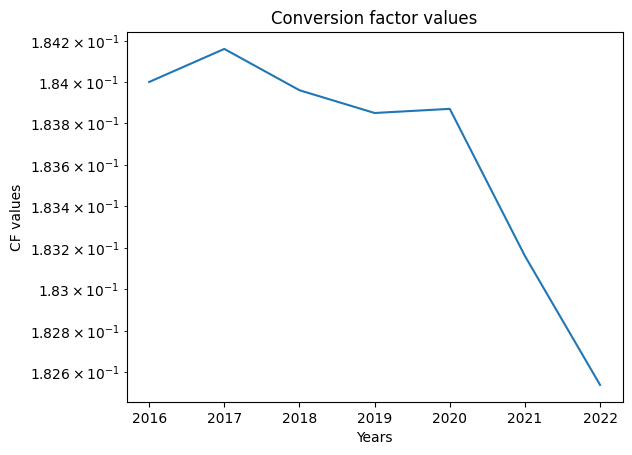

In [20]:
import matplotlib.pyplot as plt

# Create a line plot
plt.plot(years, values)

# Add labels and title
plt.xlabel('Years')
plt.ylabel('CF values')
plt.title('Conversion factor values')

# Set the y-axis scale to logarithmic
plt.yscale('log')

# Display the plot
plt.show()